# Chat Intents Tutorial

The following provides an example of using the `chatintents` package on a dataset of chat message intents to automatically extract the number of clusters and apply descriptive labels. The associated [Medium blog post](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e) provides additional detail about the `chatintents` package and this example.

The [bank77 dataset](https://github.com/PolyAI-LDN/task-specific-datasets) is used here, which contains messages representing 77 different intents from users. Four models are compared: Universal Sentence Encoder and three different Sentence Transformer models. 

In [1]:
import numpy as np
import pandas as pd
from hyperopt import hp

# for USE model
import tensorflow as tf
import tensorflow_hub as hub

# for Sentence Transformer models
from sentence_transformers import SentenceTransformer

import chatintents
from chatintents import ChatIntents

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

## Load data and pre-trained models

Load a sample of the bank77 dataset to use as an example. Larger datasets can be used but will take longer to process.

In [2]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')[['text', 'category']]
data_sample.head()

,text,category
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate
1,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit
4,Are there ways for other people to send me money?,receiving_money


In [3]:
all_intents = list(data_sample['text'])
len(all_intents)

1000

In [5]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [6]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('all-distilroberta-v1')

In [7]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

Create document embeddings for the four different models:

In [8]:
embeddings_use = embed(model_use, 'use', all_intents)
embeddings_use.shape

TensorShape([1000, 512])

In [9]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
embeddings_st1.shape

(1000, 768)

In [10]:
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
embeddings_st2.shape

(1000, 384)

In [11]:
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)
embeddings_st3.shape

(1000, 768)

In [12]:
model_use = ChatIntents(embeddings_use, 'use')
model_st1 = ChatIntents(embeddings_st1, 'st1')
model_st2 = ChatIntents(embeddings_st2, 'st2')
model_st3 = ChatIntents(embeddings_st3, 'st3')

## Results with user-supplied hyperparameters

In [14]:
clusters_manual = model_st1.generate_clusters(n_neighbors = 15, 
                                              n_components = 5, 
                                              min_cluster_size = 5, 
                                              min_samples = None,
                                              random_state=42)

In [15]:
labels_manual, cost_manual = model_st1.score_clusters(clusters_manual)
print(labels_manual)
print(cost_manual)

56
0.146


## Tuning hyperparameters

### Random hyperparameter search

Randomly evalute 100 hyperparameter combinations within user-supplied ranges.

In [17]:
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,15),
        "min_samples": [None]
    }

random_st1 = model_st1.random_search(space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
random_st1.head(20)

,run_id,n_neighbors,n_components,min_cluster_size,min_samples,label_count,cost
81,81,14,5,14,None,9,0.043
6,6,14,5,14,None,9,0.043
51,51,14,6,3,None,82,0.097
69,69,14,5,2,None,112,0.106
64,64,12,5,2,None,117,0.106
46,46,12,4,3,None,87,0.106
22,22,15,6,3,None,80,0.109
11,11,15,6,3,None,80,0.109
42,42,12,6,4,None,68,0.110
95,95,15,6,8,None,41,0.111


As seen above, we could manually inspect the random search results and apply our domain knowledge to decide which model is best. For this problem, we'd expect there to be between 30 and 100 clusters, so the third configuration in the above table seems reasonable (82 clusters and 9.7% of the data is labeled as noise).

### Bayesian optimization with Hyperopt

Rather than selecting the parameters at random, here we use hyperopt to perform a Bayesian search of the hyperparameter space. Note that the hspace dictionary must use hyperopt functions to define the hyperparameter search space.

In [19]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "min_samples": None,
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [20]:
model_use.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|████████████████████| 100/100 [05:48<00:00,  3.48s/trial, best loss: 0.113]
best:
{'min_cluster_size': 5, 'min_samples': None, 'n_components': 10, 'n_neighbors': 6, 'random_state': 42}
label count: 55


In [21]:
model_use.best_params

{'min_cluster_size': 5,
 'min_samples': None,
 'n_components': 10,
 'n_neighbors': 6,
 'random_state': 42}

In [22]:
model_use.trials.best_trial

{'state': 2,
 'tid': 80,
 'spec': None,
 'result': {'loss': 0.113, 'label_count': 55, 'status': 'ok'},
 'misc': {'tid': 80,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [80],
   'n_components': [80],
   'n_neighbors': [80]},
  'vals': {'min_cluster_size': [3], 'n_components': [7], 'n_neighbors': [3]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 10, 18, 0, 20, 0, 608000),
 'refresh_time': datetime.datetime(2021, 10, 18, 0, 20, 3, 400000)}

In [23]:
model_st1.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)                                                             

100%|████████████████████| 100/100 [05:38<00:00,  3.38s/trial, best loss: 0.056]
best:
{'min_cluster_size': 6, 'min_samples': None, 'n_components': 9, 'n_neighbors': 6, 'random_state': 42}
label count: 55


Here we see that the bayesian search resulted in a lower loss (0.056) than the previous random search above (0.097 loss).

In [24]:
model_st2.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|████████████████████| 100/100 [04:58<00:00,  2.98s/trial, best loss: 0.079]
best:
{'min_cluster_size': 7, 'min_samples': None, 'n_components': 13, 'n_neighbors': 3, 'random_state': 42}
label count: 41


In [25]:
model_st3.bayesian_search(space=hspace,
                          label_lower=label_lower, 
                          label_upper=label_upper, 
                          max_evals=max_evals)

100%|████████████████████| 100/100 [05:31<00:00,  3.32s/trial, best loss: 0.082]
best:
{'min_cluster_size': 3, 'min_samples': None, 'n_components': 14, 'n_neighbors': 9, 'random_state': 42}
label count: 88


## Visually inspect clusters

We can visualize the best clusters by using UMAP to reduce the dimensionality down to two dimensions.

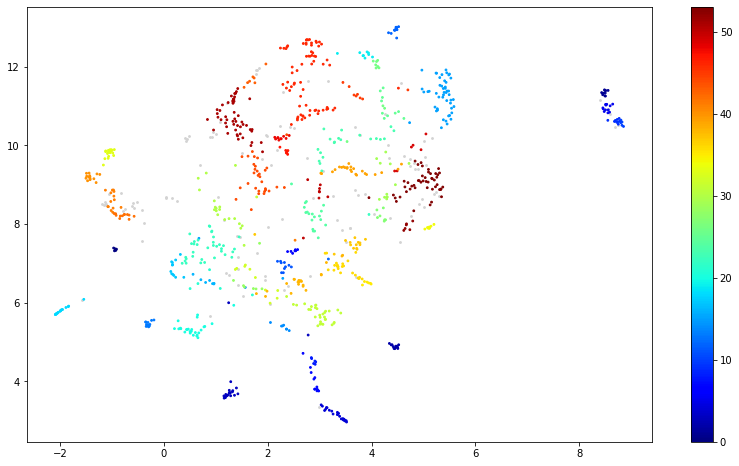

In [26]:
model_use.plot_best_clusters()

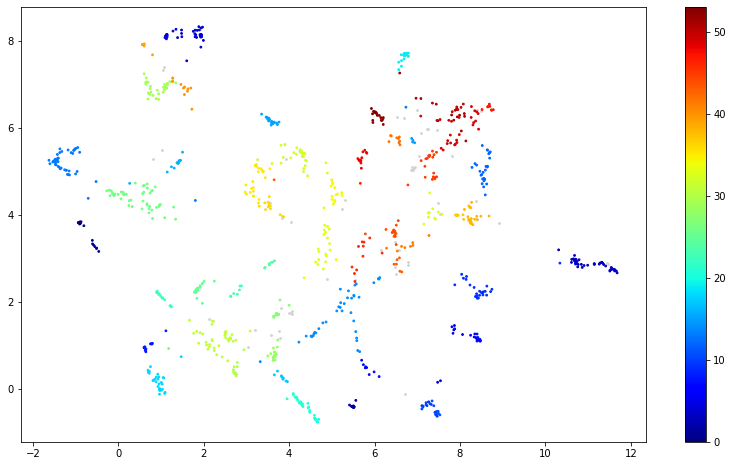

In [27]:
model_st1.plot_best_clusters()

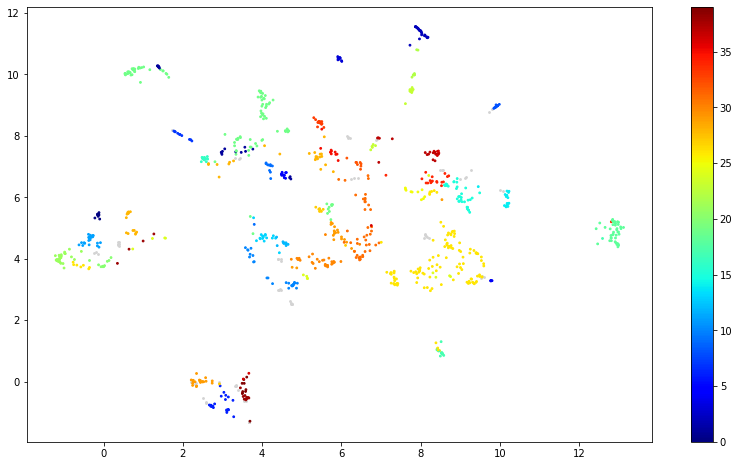

In [28]:
model_st2.plot_best_clusters()

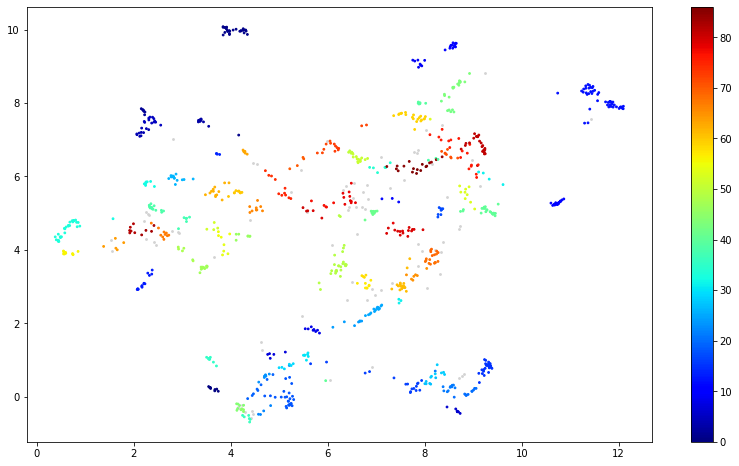

In [29]:
model_st3.plot_best_clusters()

## Apply labels

Since sentence transformer 1 achieved the lowest loss (after hyperparameter tuning), we'll select that as our best clusters. Then, we can get our final result below of clusters and applied descriptive labels, and then apply those to each document in the original dataset.

In [31]:
%%time

df_summary, labeled_docs = model_st1.apply_and_summarize_labels(data_sample[['text']])

CPU times: user 25.3 s, sys: 1.63 s, total: 27 s
Wall time: 28.3 s


In [32]:
df_summary.head()

,label_st1,count,label
0,-1,56,add_card_app
27,26,49,use_account_card_auto
14,13,45,pending_money_account
4,3,44,help_refund_statement
15,14,38,help_card_app


In [33]:
labeled_docs.head()

,text,label_st1,label
0,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,30,expect_card_week
1,I got charged a fee that shouldn't be there from my cash,32,charged_fee_withdrawal_cash
2,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,32,charged_fee_withdrawal_cash
3,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,53,deposited_cheque_balance_yesterday
4,Are there ways for other people to send me money?,51,sent_money_friend_hour


For most applications, these above two dataframes would be the final results we'd be trying to obtain.

## Evaluate clustering performance using ground truth labels

If we know the ground truth labels, then we can evaluate how well our tuned models actually did. In this case we do know the ground truth labels of the bank77 dataset so we can compare the four models evaluated.

### Comparing multiple models

In [34]:
models = [model_use, model_st1, model_st2, model_st3]

df_comparison, labeled_docs_all_models = chatintents.evaluate_models(data_sample[['text', 'category']], models)

In [35]:
df_comparison

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
1,st1,0.455,0.806,0.056,55,6,9,6,42
3,st3,0.398,0.795,0.082,88,9,14,3,42
2,st2,0.247,0.709,0.079,41,3,13,7,42
0,use,0.253,0.708,0.113,55,6,10,5,42


In agreement with our above conclusion that sentence transformer 1 would be best since it has the lowest cost, here we see that it does in fact have the highest [Adjusted Rand Index (ARI)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) and [Normalized Mutual Info (NMI)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html). Sentence transformers 2 and 3 are swithced in order in actual performance from what would be expected from their loss, but the loss measure is still a helpful metric.

In [36]:
labeled_docs_all_models.sample(5)

,text,category,label_use,label_st1,label_st2,label_st3
228,It has been forever ago that I made an order online. The product simply is not coming. Just give me back my money because I'm not paying these people.,request_refund,-1,3,18,12
940,It does not appear that my message went through.,top_up_failed,34,-1,15,76
18,How long do I have to wait until the transferred money shows up?,balance_not_updated_after_bank_transfer,15,50,26,81
98,Verify my source of funds?,verify_source_of_funds,3,19,17,11
340,I'm travelling abroad but I've run into a situation where I need to change my PIN immediately. Can I do this from here?,change_pin,31,20,19,2


In [37]:
labeled_docs_all_models[labeled_docs_all_models['label_st1']==2]

,text,category,label_use,label_st1,label_st2,label_st3
84,I don't remember my passcode?,passcode_forgotten,2,2,3,3
171,My passcode won't work.,passcode_forgotten,2,2,3,3
323,What can I do if my passcode won't work?,passcode_forgotten,2,2,3,3
359,I've forgotten my app passcode completely.,passcode_forgotten,2,2,3,3
425,I would like to better understand why my pass-code is not working.,passcode_forgotten,2,2,3,3
572,I've forgotten my passcode. Can I reset?,passcode_forgotten,2,2,3,3
778,I am entering my passcode but getting an error.,passcode_forgotten,2,2,3,3
809,Help me. The passcode doesn't work.,passcode_forgotten,2,2,3,3
810,I can't remember my password.,passcode_forgotten,2,2,3,3
920,I think my passcode was changed,passcode_forgotten,2,2,3,3


In [38]:
labeled_docs_all_models[labeled_docs_all_models['category']=='card_about_to_expire']

,text,category,label_use,label_st1,label_st2,label_st3
27,"I am overseas in China, can I get a replacement card?",card_about_to_expire,31,31,-1,-1
370,"If I am in China, can I still order a new card and if so, how?",card_about_to_expire,31,31,-1,-1
441,My card is almost expired. How fast will I get a new one and what is the cost?,card_about_to_expire,11,31,9,67
477,My card is about to expire. Do I have to go to a branch to order a new card?,card_about_to_expire,11,31,9,67
521,"My card expires soon, will you send me one automatically?",card_about_to_expire,11,31,9,67
524,My card expires very soon. What is the cost and delivery time to get a new one?,card_about_to_expire,11,31,9,67
551,Where can I have a new bank card sent to China?,card_about_to_expire,31,31,-1,37
584,How do I get a new expiration date?,card_about_to_expire,11,31,9,67
605,Are there any express fees if i want my new card faster?,card_about_to_expire,-1,31,9,-1
646,My card is almost going to expire.,card_about_to_expire,11,31,9,67


### Evaluating labels from a single model to ground truth

In [39]:
chatintents.top_cluster_category(labeled_docs, 
                                 data_sample[['text', 'category']], 
                                 'text',
                                 df_summary).head(20)

,label_st1,count,label,top_ground_category,top_cat_count,perc_top_cat
0,-1,56,add_card_app,beneficiary_not_allowed,8,14
1,26,49,use_account_card_auto,automatic_top_up,14,29
2,13,45,pending_money_account,pending_top_up,14,31
3,3,44,help_refund_statement,Refund_not_showing_up,26,59
4,14,38,help_card_app,lost_or_stolen_card,10,26
5,31,37,like_card_cost,order_physical_card,15,41
6,4,36,think_rate_exchange,wrong_exchange_rate_for_cash_withdrawal,14,39
7,33,31,tried_money_card_today,declined_cash_withdrawal,14,45
8,32,31,charged_fee_withdrawal_cash,cash_withdrawal_charge,23,74
9,29,29,use_currency_app,fiat_currency_support,10,34


Most of the extracted labels match the ground labels quite well. Understandably, the labels match the most when the derived clusters contain a larger percentage of the dominant ground truth category.